<a href="https://colab.research.google.com/github/haricharan123461/Sentiment-GenAI/blob/main/Modern_ALG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AUDIO PART

In [ ]:
########AUDIO PART###########

In [ ]:
pip install SpeechRecognition pydub chardet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 23.6 MB/s eta 0:00:00


In [ ]:
#Read input files
import base64
import csv

# List of WAV files
wavfiles = [ "/content/p1.wav","/content/dd2.wav" ]

# Create CSV file to store file paths
csv_filename = "csvout.csv"

with open(csv_filename, 'w', newline='') as fileout:
    writer = csv.writer(fileout)
    writer.writerow(["Audio File"])  # Write header
    for wav in wavfiles:
        writer.writerow([wav])

print(f"WAV file paths saved to {csv_filename}")


WAV file paths saved to csvout.csv


In [ ]:
#processing part of speech to text
import speech_recognition as sr
import os
import csv
import sys
import chardet
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Increase CSV field size limit to prevent errors
maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

# Create a speech recognition object
r = sr.Recognizer()

# Function to transcribe a single audio file
def transcribe_audio(path):
    with sr.AudioFile(path) as source:
        audio_listened = r.record(source)
        try:
            text = r.recognize_google(audio_listened)
        except sr.UnknownValueError:
            text = "[Unrecognized Audio]"
    return text

# Function to split large audio files into chunks and transcribe them
def get_large_audio_transcription_on_silence(path):
    sound = AudioSegment.from_file(path)
    chunks = split_on_silence(sound,
        min_silence_len=500,
        silence_thresh=sound.dBFS-14,
        keep_silence=500,
    )

    folder_name = "audio-chunks"
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

    whole_text = ""
    for i, audio_chunk in enumerate(chunks, start=1):
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        try:
            text = transcribe_audio(chunk_filename)
        except sr.UnknownValueError:
            text = "[Unrecognized Audio]"
        else:
            text = f"{text.capitalize()}. "
            print(chunk_filename, ":", text)
            whole_text += text

    return whole_text


In [ ]:
# Function to process CSV input and generate transcriptions
def process_csv(input_csv, output_csv):
    # Detect file encoding
    with open(input_csv, 'rb') as rawdata:
        result = chardet.detect(rawdata.read())
    file_encoding = result['encoding']

    with open(input_csv, newline='', encoding=file_encoding) as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)  # Skip header
        audio_files = [row[0] for row in reader]

    transcriptions = []
    for audio_path in audio_files:
        if os.path.exists(audio_path):
            print(f"Processing: {audio_path}")
            transcription = get_large_audio_transcription_on_silence(audio_path)
        else:
            transcription = "[File Not Found]"
        transcriptions.append([audio_path, transcription])

    # Save transcriptions to CSV
    with open(output_csv, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Audio File", "Transcription"])
        writer.writerows(transcriptions)

# Process the CSV and generate transcriptions
input_csv = "csvout.csv"
output_csv = "transcriptions.csv"
process_csv(input_csv, output_csv)

print(f"Transcriptions saved to {output_csv}")

Processing: /content/p1.wav
audio-chunks/chunk1.wav : The address was exactly as shown in the pictures the fabric is soft fluffy and feels great on the skin. 
audio-chunks/chunk2.wav : I received many compliments. 
Processing: /content/dd2.wav
audio-chunks/chunk1.wav : The fabric is so thin. 
audio-chunks/chunk2.wav : Find transparent i expected something better for the price i paid. 
Transcriptions saved to transcriptions.csv


# Text Processing, Ratings and Emojis

In [ ]:
#DATASET PREPROCESSING

In [ ]:
pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 36.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import io
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from emoji import demojize  # Convert emojis to text

# Download required NLTK resources (only once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# **Define the file_path variable**
file_path = "dataset.csv"  # Replace with the actual path to your dataset file

with open(file_path, 'r', encoding="utf-8", errors='replace') as file:
    # Replace potential incorrect line endings
    content = file.read().replace('\r\n', '\n')

    # Create a StringIO object to treat the content as a file-like object
    csv_data = io.StringIO(content)

    # Read the CSV data using pandas with error handling
    df = pd.read_csv(csv_data, on_bad_lines='skip', engine='python', quotechar='"')

# Display initial dataset
print("\U0001F4C1 Initial Data:\n", df.head())

# Step 1: Handle Missing Values
df.dropna(subset=['Review Text', 'Title', 'Ratings'], inplace=True)  # Remove rows with missing essential values
df.fillna("", inplace=True)  # Fill other missing values with an empty string

# Step 2: Remove Duplicates
df.drop_duplicates(subset=['Review Text'], keep='first', inplace=True)

# Step 3: Convert text to lowercase
def to_lowercase(text):
    return text.lower()

# Step 4: Convert emojis to text
def convert_emojis(text):
    return demojize(text, delimiters=(" ", " "))

# Step 5: Remove punctuation, numbers, and special characters
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Step 6: Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Step 7: Remove Stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Step 8: Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Step 9: Apply all preprocessing steps to 'Review Text' and 'Title'
def preprocess_text(text):
    text = to_lowercase(text)
    text = convert_emojis(text)  # Convert emojis to text
    text = clean_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return demojize(text, delimiters=(" ", " "))

df['Cleaned Review'] = df['Review Text'].apply(preprocess_text)
df['Cleaned Title'] = df['Title'].apply(preprocess_text)

# Step 10: Convert Ratings to Sentiment Labels
def categorize_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Ratings'].apply(categorize_rating)

# Display processed data
print("\n\U0001F4C1 Processed Data:\n", df[['ID', 'Cleaned Review', 'Cleaned Title', 'Ratings', 'Sentiment']].head())

# Step 11: Save cleaned data to a new CSV file
df.to_csv("cleaned_dataset.csv", index=False)
print("\n\u2705 Data preprocessing complete! Cleaned data saved as 'cleaned_dataset.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


📁 Initial Data:
    Unnamed: 0    ID  Age                    Title  \
0           0   767   33                      NaN   
1           1  1080   34                      NaN   
2           2  1077   60  Some major design flaws   
3           3  1049   50         My favorite buy!   
4           4   847   47         Flattering shirt   

                                         Review Text  Ratings  \
0  Absolutely wonderful - silky and sexy and comf...        4   
1  Love this dress!  it's sooo pretty.  i happene...        5   
2  I had such high hopes for this dress and reall...        3   
3  I love, love, love this jumpsuit. it's fun, fl...        5   
4  This shirt is very flattering to all due to th...        5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                  

In [ ]:
#Feature Extraction for Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import pickle
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Fixing random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the cleaned dataset
df = pd.read_csv("cleaned_dataset.csv")

# Check for null values (optional but useful)
assert df['Cleaned Review'].notnull().all(), "❌ Missing reviews found!"

# Step 1: Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Handle out-of-vocabulary words
tokenizer.fit_on_texts(df['Cleaned Review'])

# Convert reviews to sequences
X = tokenizer.texts_to_sequences(df['Cleaned Review'])
X = pad_sequences(X, padding='post', maxlen=100)

# Step 2: Encode sentiment labels
y = pd.get_dummies(df['Sentiment']).values

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify for balanced label split
)

# Step 4: Save tokenizer and data
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save word index separately (optional)
with open('word_index.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

# Save the processed data
np.savez_compressed('feature_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

print("\n✅ Feature extraction complete! Tokenizer and data saved.")



✅ Feature extraction complete! Tokenizer and data saved.


In [ ]:
#displaying the numericals to text

In [ ]:
import numpy as np
import pickle

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the feature data
data = np.load('feature_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Select the top 2 reviews from the dataset (you can choose from X_train or X_test)
top_reviews_idx = [0, 1]  # Index for the top 2 reviews

# Decode the tokenized reviews back into words using the tokenizer's word index
reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}

def decode_review(review_sequence):
    # Map the sequence of integers back to words
    return ' '.join([reverse_word_index.get(i, '?') for i in review_sequence])

# Get the tokenized sequences for the top 2 reviews
top_reviews_sequences = X_train[top_reviews_idx]

# Decode and display the reviews along with their tokenized values
for idx in top_reviews_idx:
    print(f"\nTop Review {idx + 1} (Tokenized):")
    print(f"Tokenized Sequence: {X_train[idx]}")
    print(f"Decoded Review: {decode_review(X_train[idx])}")



Top Review 1 (Tokenized):
Tokenized Sequence: [   2  188    7   42    4  108  419    3   38   16  316    2  102    5
   11   35  104   98    9  103  203   10   12    7   88    2 1440  187
   12    4  171   25    1  279  250    6  655    3   24   99    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Decoded Review: i saw this at a store today and am so glad i tried it on im usually xs in retailer tops but for this shirt i preferred s for a loose fit the lace detail is elegant and very pretty ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?

Top Review 2 (Tokenized):
Tokenized Sequence: [   2   38  169    8  559    7   99   83    1  117    1  163 1579   13
   32 2723

In [ ]:
#Model evaluation and trainig

In [ ]:
pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load processed data
data = np.load('feature_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = np.argmax(data['y_train'], axis=1)
y_test = np.argmax(data['y_test'], axis=1)

# Re-encode one-hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Hyperparameters
vocab_size = 5000
embedding_dim = 128
max_sequence_length = 100
batch_size = 64
epochs = 5

# Build improved LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Use Bidirectional LSTM for better context understanding
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))

# Optional additional dense layer
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred))

# Save the model
model.save('final_sentiment_lstm_model.h5')
print("\n✅ Model saved as 'final_sentiment_lstm_model.h5'")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7574 - loss: 0.7104

246/246 ━━━━━━━━━━━━━━━━━━━━ 188s 682ms/step - accuracy: 0.7574 - loss: 0.7100 - val_accuracy: 0.7997 - val_loss: 0.4775
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.7879 - loss: 0.4939

246/246 ━━━━━━━━━━━━━━━━━━━━ 184s 628ms/step - accuracy: 0.7879 - loss: 0.4938 - val_accuracy: 0.8068 - val_loss: 0.4610
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8104 - loss: 0.4430

246/246 ━━━━━━━━━━━━━━━━━━━━ 202s 630ms/step - accuracy: 0.8104 - loss: 0.4430 - val_accuracy: 0.8094 - val_loss: 0.4466
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 158s 644ms/step - accuracy: 0.8205 - loss: 0.4130 - val_accuracy: 0.8106 - val_loss: 0.4604
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 197s 625ms/step - accuracy: 0.8241 - loss: 0.4034 - val_accuracy: 0.8099 - val_loss: 0.4530

✅ Test Accuracy: 80.94%
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step



Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.65      0.52       410
           1       0.37      0.13      0.19       493
           2       0.91      0.94      0.92      3031

    accuracy                           0.81      3934
   macro avg       0.57      0.57      0.54      3934
weighted avg       0.79      0.81      0.79      3934


Confusion Matrix:
 [[ 266   46   98]
 [ 231   62  200]
 [ 117   58 2856]]

✅ Model saved as 'final_sentiment_lstm_model.h5'


In [ ]:
#Sentiment Scoring & Interpretation

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# Load the trained LSTM model
model = load_model('final_sentiment_lstm_model.h5')  # Match the filename you saved during training

# Load the saved tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Define max_sequence_length (same as during training)
max_sequence_length = 100

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned Review'].astype(str))

# Pad the sequences
X_reviews = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Predict sentiment probabilities
sentiment_probabilities = model.predict(X_reviews)

# Get predicted class indices
predicted_classes = np.argmax(sentiment_probabilities, axis=1)

# Map class indices to labels
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [sentiment_labels[i] for i in predicted_classes]

# Add predictions to the DataFrame
df['Predicted Sentiment'] = predicted_sentiments
df['Sentiment Score'] = sentiment_probabilities.max(axis=1)

# Save results
df.to_csv('dataset_with_sentiment_scores.csv', index=False)

# Display sample output
print(df[['Cleaned Review', 'Predicted Sentiment', 'Sentiment Score']].head())


615/615 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step
                                      Cleaned Review Predicted Sentiment  \
0  i had such high hopes for this dress and reall...            Negative   
1  i love love love this jumpsuit its fun flirty ...            Positive   
2  this shirt is very flattering to all due to th...            Positive   
3  i love tracy reese dresses but this one is not...             Neutral   
4  i aded this in my basket at hte last mintue to...            Positive   

   Sentiment Score  
0         0.528547  
1         0.992033  
2         0.979079  
3         0.370130  
4         0.949679  


In [ ]:
#Visualization & Reporting

<ipython-input-43-3da60778e517>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted Sentiment', data=df, palette='Set2', order=['Positive', 'Neutral', 'Negative'])


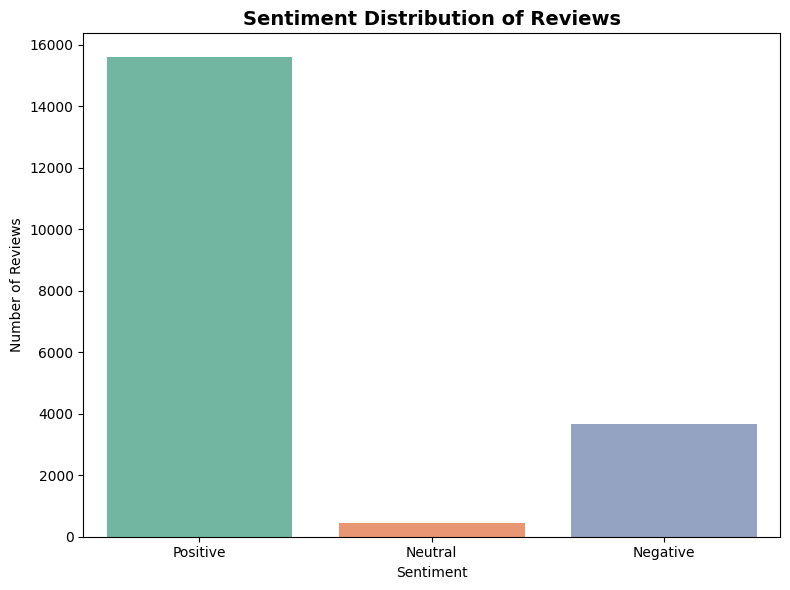

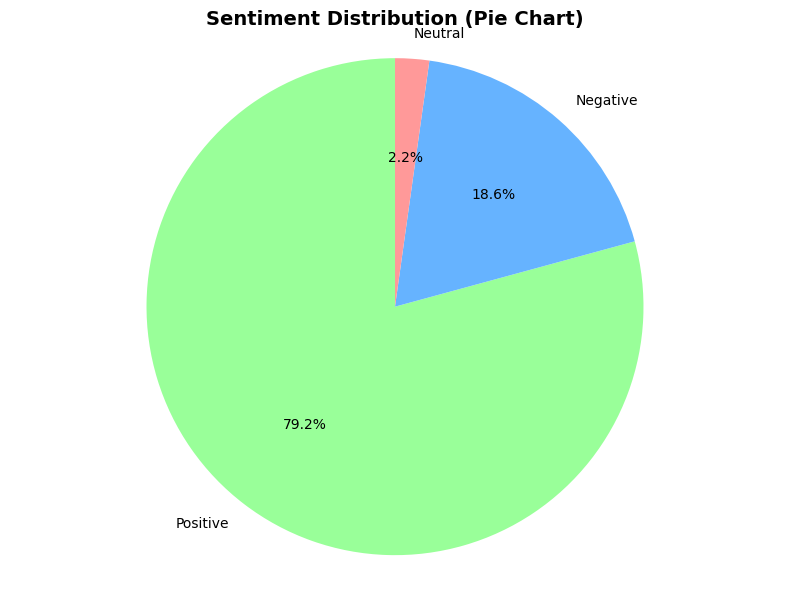

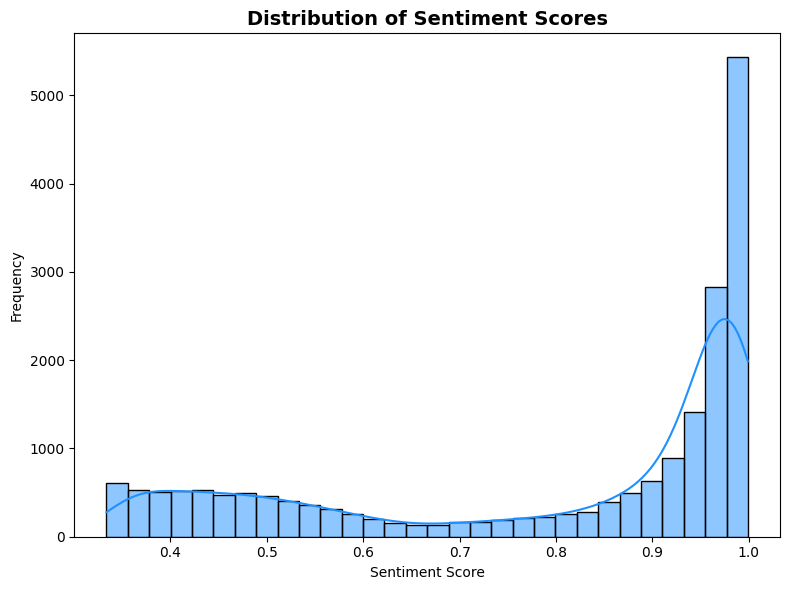

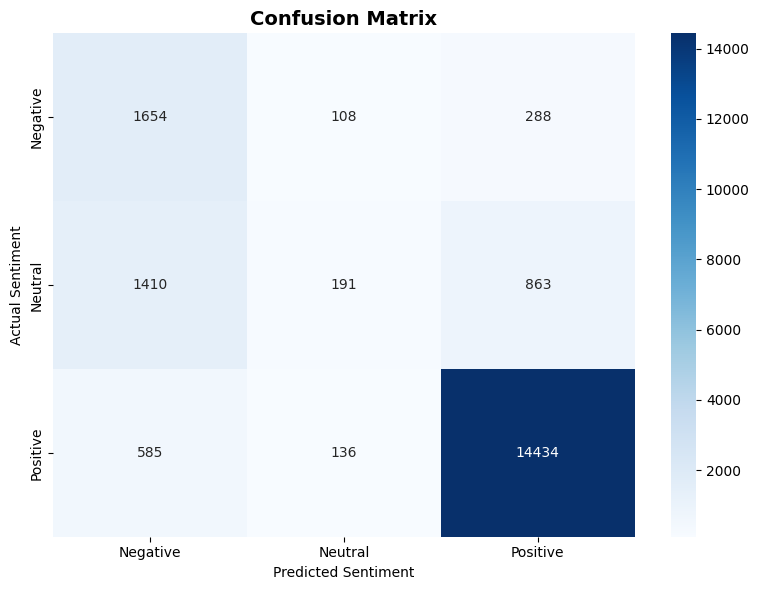


Classification Report:
              precision    recall  f1-score   support

    Negative       0.45      0.81      0.58      2050
     Neutral       0.44      0.08      0.13      2464
    Positive       0.93      0.95      0.94     15155

    accuracy                           0.83     19669
   macro avg       0.61      0.61      0.55     19669
weighted avg       0.82      0.83      0.80     19669


--- Sentiment Analysis Report ---
Total reviews analyzed: 19669
Positive reviews: 15585 (79.24%)
Neutral reviews: 435 (2.21%)
Negative reviews: 3649 (18.55%)

Average Sentiment Score: 0.79


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset with sentiment predictions and actual sentiments (if present)
df = pd.read_csv('dataset_with_sentiment_scores.csv')

# --- Visualization 1: Sentiment Distribution (Bar Chart) ---
plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted Sentiment', data=df, palette='Set2', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution of Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

# --- Visualization 2: Pie Chart ---
plt.figure(figsize=(8, 6))
sentiment_counts = df['Predicted Sentiment'].value_counts()
colors = ['#99ff99', '#66b3ff', '#ff9999']  # Match order with Positive, Neutral, Negative
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Sentiment Distribution (Pie Chart)', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# --- Visualization 3: Sentiment Score Distribution ---
plt.figure(figsize=(8, 6))
sns.histplot(df['Sentiment Score'], kde=True, color='dodgerblue', bins=30)
plt.title('Distribution of Sentiment Scores', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Confusion Matrix & Classification Report (if actual labels exist) ---
if 'Sentiment' in df.columns:
    sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    df['Predicted Sentiment Numeric'] = df['Predicted Sentiment'].map(sentiment_map)
    df['Actual Sentiment Numeric'] = df['Sentiment'].map(sentiment_map)

    # Drop NaNs just in case
    df_clean = df.dropna(subset=['Predicted Sentiment Numeric', 'Actual Sentiment Numeric'])

    cm = confusion_matrix(df_clean['Actual Sentiment Numeric'], df_clean['Predicted Sentiment Numeric'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Actual Sentiment')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_clean['Actual Sentiment Numeric'], df_clean['Predicted Sentiment Numeric'],
                                target_names=['Negative', 'Neutral', 'Positive']))

# --- Textual Report ---
positive_count = df['Predicted Sentiment'].value_counts().get('Positive', 0)
neutral_count = df['Predicted Sentiment'].value_counts().get('Neutral', 0)
negative_count = df['Predicted Sentiment'].value_counts().get('Negative', 0)
total_reviews = len(df)

positive_percentage = (positive_count / total_reviews) * 100
neutral_percentage = (neutral_count / total_reviews) * 100
negative_percentage = (negative_count / total_reviews) * 100
avg_score = df['Sentiment Score'].mean()

# Print Summary
print("\n--- Sentiment Analysis Report ---")
print(f"Total reviews analyzed: {total_reviews}")
print(f"Positive reviews: {positive_count} ({positive_percentage:.2f}%)")
print(f"Neutral reviews: {neutral_count} ({neutral_percentage:.2f}%)")
print(f"Negative reviews: {negative_count} ({negative_percentage:.2f}%)")
print(f"\nAverage Sentiment Score: {avg_score:.2f}")


In [ ]:
#Particular Review by ID


There are 251 reviews for ID 1077. Displaying the first 5 records:
                                          Review Text Predicted Sentiment  \
0   I had such high hopes for this dress and reall...             Neutral   
6   I love this dress. i usually get an xs but it ...            Positive   
7   I'm 5"5' and 125 lbs. i ordered the s petite t...            Positive   
8   Dress runs small esp where the zipper area run...            Negative   
11  This is a nice choice for holiday gatherings. ...            Positive   

    Sentiment Score  
0          0.441271  
6          0.977446  
7          0.970936  
8          0.421087  
11         0.506032  

Average Sentiment Scores by Category:
Predicted Sentiment
Negative    0.407838
Neutral     0.408158
Positive    0.896128
Name: Sentiment Score, dtype: float64


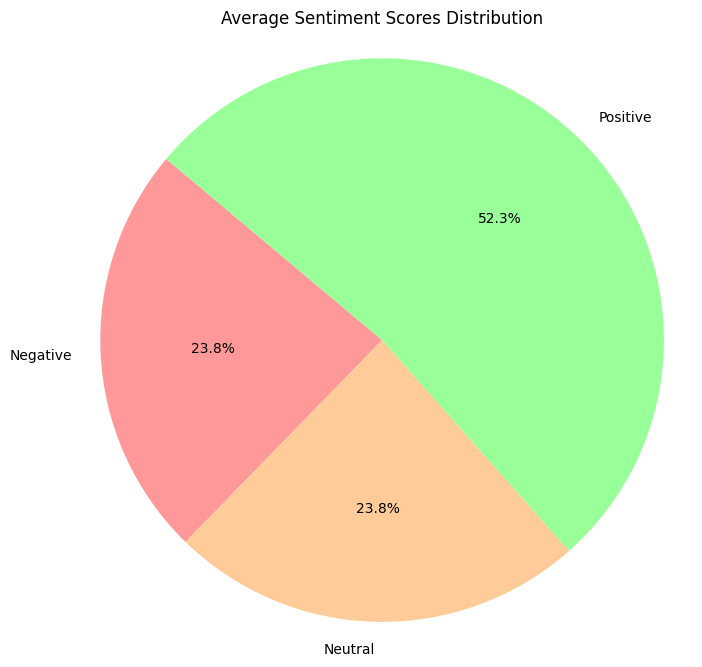

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset with sentiment predictions and actual sentiments (if available)
df = pd.read_csv('dataset_with_sentiment_scores.csv')

# --- Step 1: Choose Review ID to Analyze ---
# For example, if there are many reviews on ID 1077, we set it here:
review_id_to_analyze = 1077  # Change this value as needed

# --- Step 2: Extract the Reviews for the Chosen ID ---
review_data = df[df['ID'] == review_id_to_analyze]

if review_data.empty:
    print(f"No review found with ID {review_id_to_analyze}")
else:
    if len(review_data) == 1:
        # Display the single review details
        print("\n--- Review Details ---")
        print("Review ID:", review_id_to_analyze)
        print("Review Text:\n", review_data['Review Text'].iloc[0])
        print("Predicted Sentiment:", review_data['Predicted Sentiment'].iloc[0])
        print("Sentiment Score:", review_data['Sentiment Score'].iloc[0])
        if 'Sentiment' in review_data.columns:
            print("Actual Sentiment:", review_data['Sentiment'].iloc[0])
    else:
        # If multiple reviews exist for the same ID, display the first few records
        print(f"\nThere are {len(review_data)} reviews for ID {review_id_to_analyze}. Displaying the first 5 records:")
        print(review_data[['Review Text', 'Predicted Sentiment', 'Sentiment Score']].head(5))

# --- Step 3: Visualize the Average Sentiment Scores for Each Category Across All Reviews ---

# Compute the average sentiment score for each predicted sentiment category.
# Note: This assumes that the 'Sentiment Score' column contains a numerical score
# (e.g., model's probability/confidence) and that predicted sentiment is in 'Predicted Sentiment'.
avg_scores = df.groupby('Predicted Sentiment')['Sentiment Score'].mean()
print("\nAverage Sentiment Scores by Category:")
print(avg_scores)

# Create a pie chart based on the average sentiment scores
plt.figure(figsize=(8, 8))

# Define a color mapping for the sentiments
colors = {'Positive': '#99ff99', 'Neutral': '#ffcc99', 'Negative': '#ff9999'}
labels = avg_scores.index.tolist()
sizes = avg_scores.values.tolist()
# Use the defined colors; if a label is not in our mapping, a default color is provided
pie_colors = [colors.get(label, '#66b3ff') for label in labels]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=pie_colors)
plt.title('Average Sentiment Scores Distribution')
plt.axis('equal')
plt.show()


In [ ]:
#AUDIO REVIEWS

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

# Load the new dataset (e.g., audio transcription input file)
input_path = 'transcriptions.csv'  # Replace with your actual input file path
df_new = pd.read_csv(input_path)

# Load tokenizer
with open('/content/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Define max_length used during training (update if known)
max_length = 100  # This should match the max length used during training

# Tokenize and pad the new transcription data
transcription_texts = df_new['Transcription'].astype(str).values
sequences = tokenizer.texts_to_sequences(transcription_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Load the trained sentiment analysis model
model = load_model('/content/final_sentiment_lstm_model.h5')

# Predict sentiment scores
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)

# Map numeric predictions to sentiment labels
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df_new['Sentiment Score'] = predictions.max(axis=1)  # Max probability as score
df_new['Predicted Sentiment'] = [label_map[i] for i in predicted_labels]

# Save the results
output_path = '/content/audio_transcription_sentiment_predictions.csv'
df_new.to_csv(output_path, index=False)
print(f"✅ Sentiment predictions saved to: {output_path}")

# Display few results
print("\n🔍 Sample Predictions:")
print(df_new[['Audio File', 'Transcription', 'Predicted Sentiment', 'Sentiment Score']].head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
✅ Sentiment predictions saved to: /content/audio_transcription_sentiment_predictions.csv

🔍 Sample Predictions:
         Audio File                                      Transcription  \
0   /content/p1.wav  The address was exactly as shown in the pictur...   
1  /content/dd2.wav  The fabric is so thin. Find transparent i expe...   

  Predicted Sentiment  Sentiment Score  
0            Positive         0.709154  
1            Positive         0.709154  


# **ChatBot**

In [ ]:
##############CHAT BOT#######

In [ ]:
pip install --upgrade google-generativeai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: google-generativeai
    Found existing installation: google-generativeai 0.8.4
    Uninstalling google-generativeai-0.8.4:
      Successfully uninstalled google-generativeai-0.8.4


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install nltk gradio textblob google-generativeai


In [ ]:
!pip uninstall google-generativeai -y
!pip install --upgrade google-generativeai


Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
Using cached google_generativeai-0.8.5-py3-none-any.whl (155 kB)


In [ ]:
!pip install transformers sentencepiece torch gradio textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import nltk
import gradio as gr
from textblob import TextBlob
import openai
import os

# Set your OpenAI API key (you can set it as an environment variable)
openai.api_key = os.getenv("OPENAI_API_KEY")  # or replace with your key: "sk-..."

# Download required NLTK data
nltk.download('punkt')

# Generate marketing suggestion using GPT-4.5 (via ChatCompletion)
def generate_marketing_suggestion(sentiment, text):
    prompt = (
        f"The following is a customer review with a {sentiment.lower()} sentiment:\n"
        f"\"{text}\"\n\n"
        f"Based on this review, suggest how to improve the product or describe it more effectively "
        f"so it can attract more customers and follow current market trends.\n\n"
        f"Marketing Suggestion:"
    )

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4.5-turbo",
            messages=[
                {"role": "system", "content": "You are a marketing assistant who provides actionable suggestions."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100,
            temperature=0.7
        )

        suggestion = response['choices'][0]['message']['content'].strip()

        if "Marketing Suggestion:" in suggestion:
            suggestion = suggestion.split("Marketing Suggestion:")[-1].strip()

        return suggestion

    except Exception as e:
        return f"Error generating suggestion: {e}"

# Analyze sentiment and get marketing suggestion
def analyze_sentiment_with_suggestions(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    sentiment = "Positive" if polarity > 0 else "Negative" if polarity < 0 else "Neutral"

    suggestion = generate_marketing_suggestion(sentiment, text)

    result = (
        f"**Sentiment:** {sentiment}\n"
        f"**Polarity:** {polarity:.2f}\n"
        f"**Marketing Suggestion:** {suggestion}"
    )
    return result

# Gradio Interface
interface = gr.Interface(
    fn=analyze_sentiment_with_suggestions,
    inputs=gr.Textbox(lines=3, placeholder="Enter product review or feedback..."),
    outputs=gr.Markdown(),
    title="Sentiment Analysis with GPT-4.5 Marketing Suggestions",
    description="This tool uses GPT-4.5 to analyze customer feedback and suggest how to better market the product."
)

# Launch app
interface.launch(share=True)


Device set to use cuda:0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://59932e5bf50dae5fc0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
